# Imports


In [2]:
import essentia.standard as es
import numpy as np
import os
from matplotlib import pyplot as plt
from scipy.signal import resample

# Functions


In [3]:
def trim_wave(wave, idx):
    frame_size = len(wave)
    pitchYin = es.PitchYin(frameSize=frame_size)
    pitch, pitchconf = pitchYin(wave)
    if pitchconf < 0.8:
        raise ValueError("Pitch confidence too low")
    period = 1.0 / pitch
    period_samples = int(period * 44100)

    zero_crossings = np.where(np.diff(np.sign(wave)) > 0)[0]
    if len(zero_crossings) > 0:
        start = zero_crossings[0]
        trimmed_wave = wave[start : start + period_samples]
    else:
        trimmed_wave = wave[:period_samples]

    return trimmed_wave

# Audio Loading


In [4]:
audio_dir = "def samples"
audio_files = sorted(os.listdir(audio_dir))
audio_data = []
for file in audio_files:
    loader = es.MonoLoader(filename=os.path.join(audio_dir, file), sampleRate=44100)
    audio = loader()
    audio_data.append(audio)
audio_data = np.array(audio_data)
audio_data_trimmed = []
for i in range(len(audio_data)):
    wave = audio_data[i]
    trimmed_wave = trim_wave(wave, i)
    audio_data_trimmed.append(trimmed_wave)

audios = np.array(audio_data_trimmed)
# pot_values = np.linspace(0, 4, len(audio_data_trimmed))
pot_values = np.linspace(0, 4, 20)
print(pot_values)
# drop index 8 from pot_values
pot_values = np.delete(pot_values, 8)
print(pot_values)

[0.         0.21052632 0.42105263 0.63157895 0.84210526 1.05263158
 1.26315789 1.47368421 1.68421053 1.89473684 2.10526316 2.31578947
 2.52631579 2.73684211 2.94736842 3.15789474 3.36842105 3.57894737
 3.78947368 4.        ]
[0.         0.21052632 0.42105263 0.63157895 0.84210526 1.05263158
 1.26315789 1.47368421 1.89473684 2.10526316 2.31578947 2.52631579
 2.73684211 2.94736842 3.15789474 3.36842105 3.57894737 3.78947368
 4.        ]


# Linear Interpolation


In [5]:
from scipy.interpolate import interp1d


def predicted_output_lininter(pot_value, pot_values=pot_values, audios=audios):
    if pot_value < 0 or pot_value > 4:
        raise ValueError("Pot value must be between 0 and 4")
    print(pot_values.shape, audios.shape)
    interpolator = interp1d(pot_values, audios, axis=0, kind="linear")
    return interpolator(pot_value)

## Graphs


(19,) (19, 100)


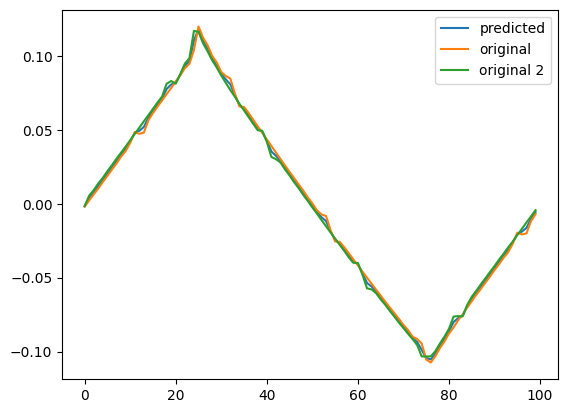

(19,) (19, 100)


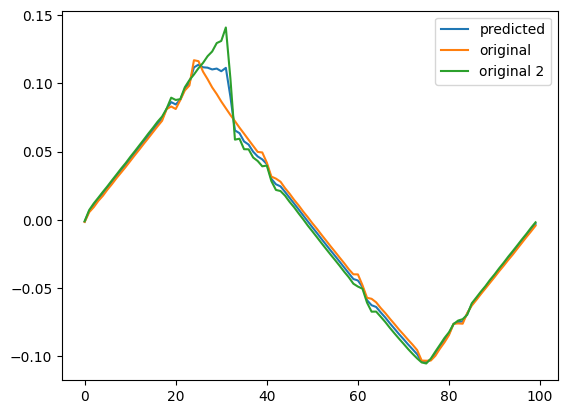

(19,) (19, 100)


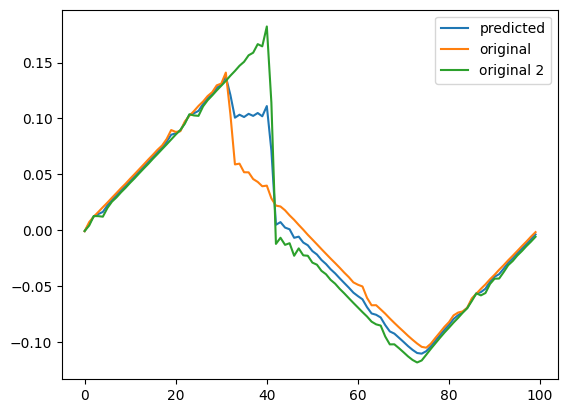

(19,) (19, 100)


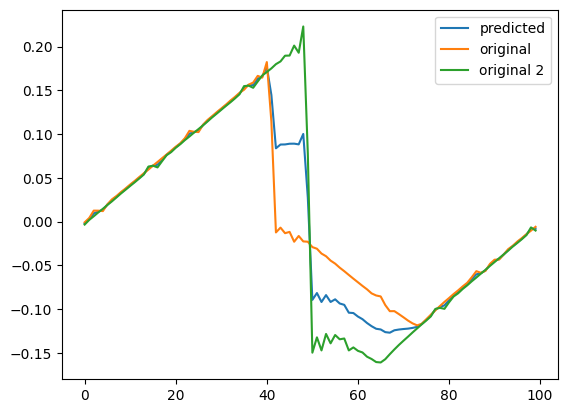

(19,) (19, 100)


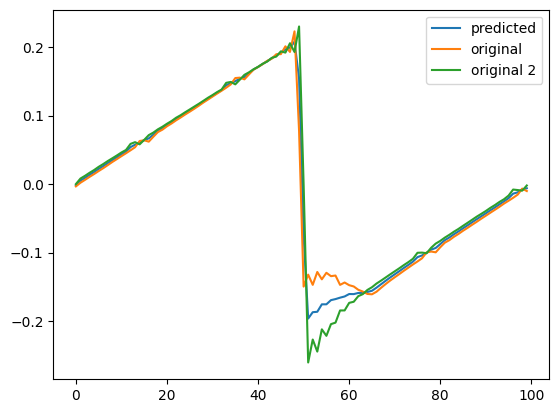

(19,) (19, 100)


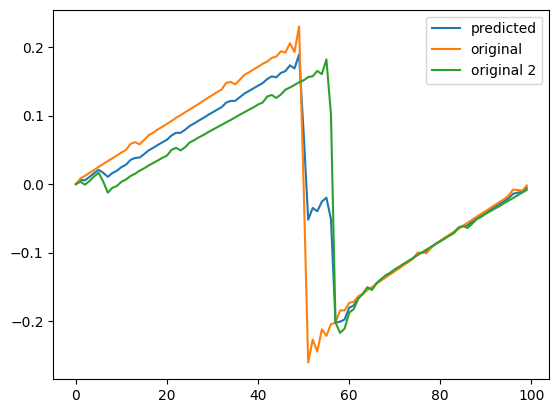

(19,) (19, 100)


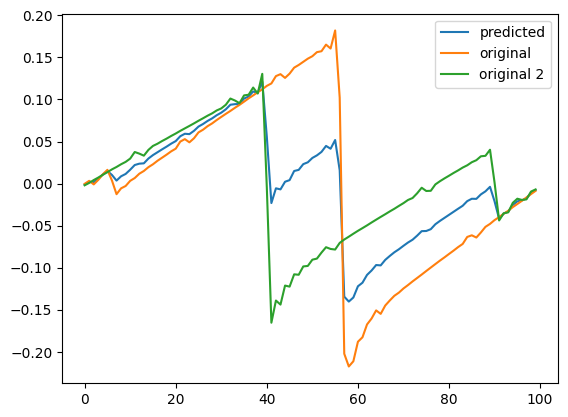

(19,) (19, 100)


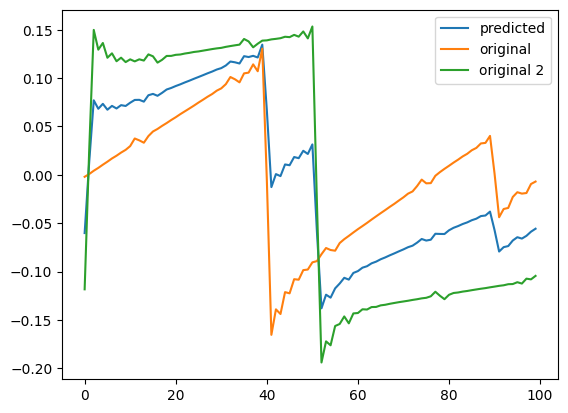

(19,) (19, 100)


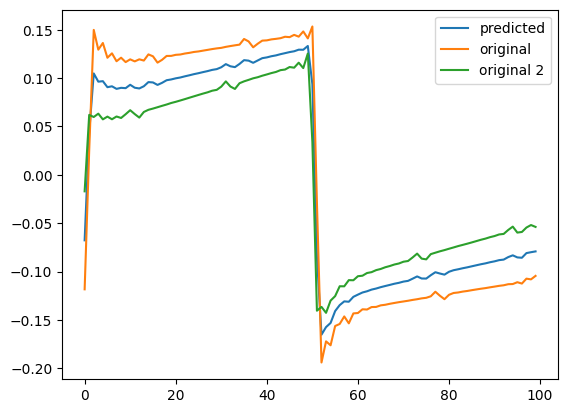

(19,) (19, 100)


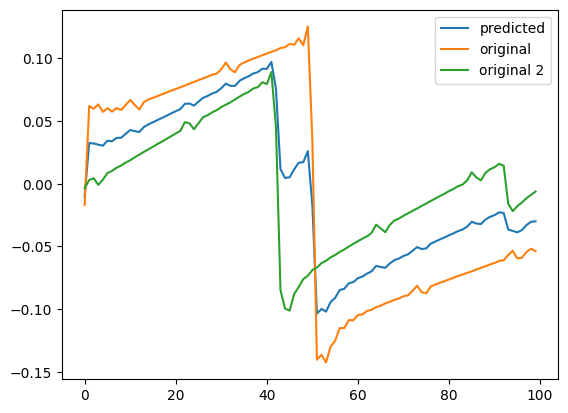

(19,) (19, 100)


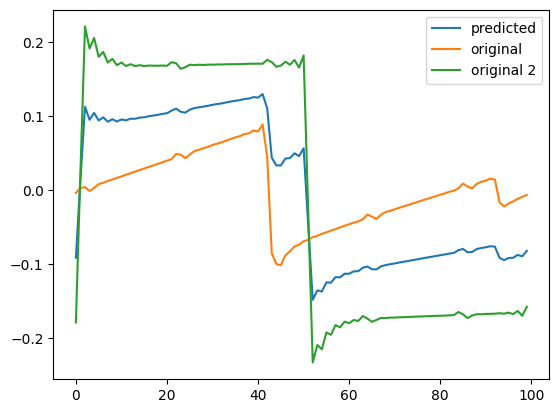

(19,) (19, 100)


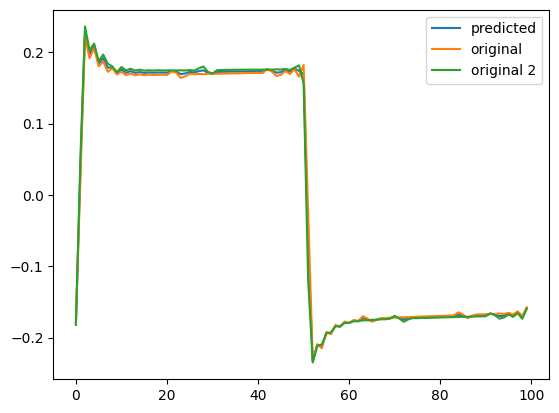

(19,) (19, 100)


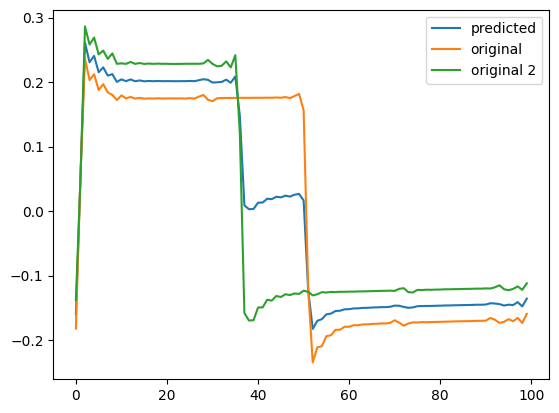

(19,) (19, 100)


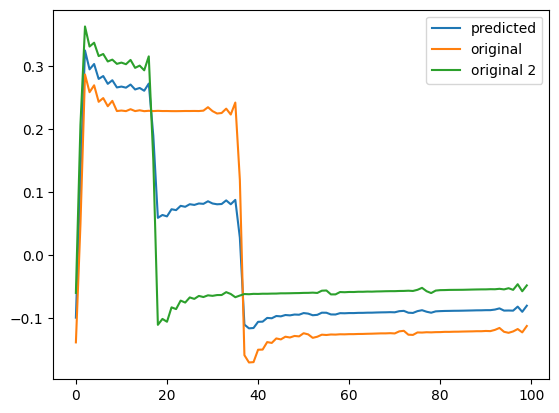

(19,) (19, 100)


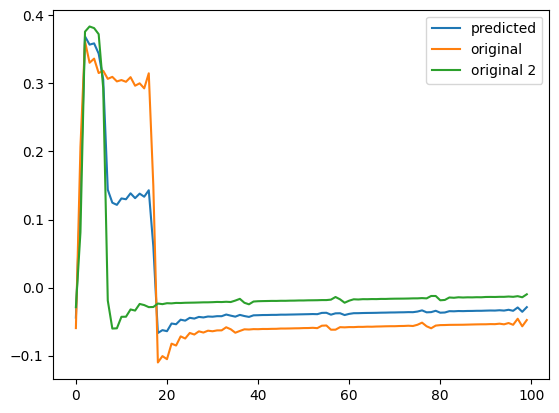

(19,) (19, 100)


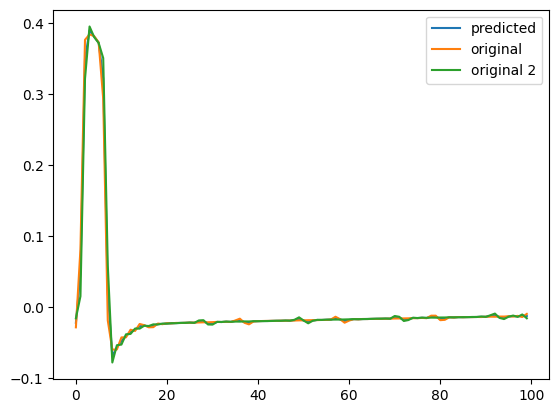

(19,) (19, 100)


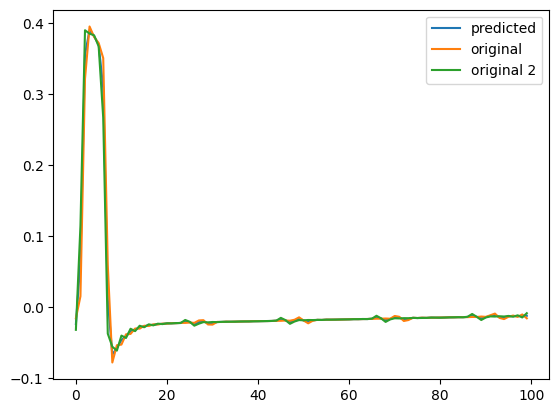

(19,) (19, 100)


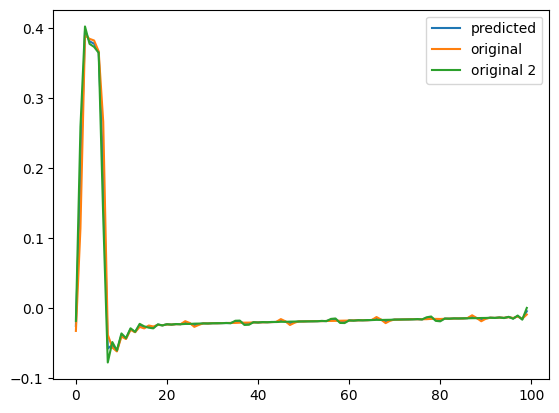

In [6]:
# test_pot_value = (pot_values[0] + pot_values[1])/2
# output = predicted_output_lininter(test_pot_value)
# plt.plot(output, label = 'predicted')
# plt.plot(audios[0], label = 'original')
# plt.plot(audios[1], label = 'original 2')
# plt.legend()
# plt.show()

for i in range(len(pot_values) - 1):
    test_pot_value = (pot_values[i] + pot_values[i + 1]) / 2
    output = predicted_output_lininter(test_pot_value)
    plt.plot(output, label="predicted")
    plt.plot(audios[i], label="original")
    plt.plot(audios[i + 1], label="original 2")
    plt.legend()
    plt.show()

## MSE


In [7]:
inter_pot = (pot_values[0] + pot_values[1]) / 2
output = predicted_output_lininter(inter_pot)
mse = np.mean((output - audios[1]) ** 2)
print(mse)

(19,) (19, 100)
3.513502888381481e-06


# Polynomial Regression


In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


def predicted_output_poly(pot_value, degree, pot_values=pot_values, audios=audios):
    if pot_value < 0 or pot_value > 4:
        raise ValueError("Pot value must be between 0 and 4")
    poly_feat = PolynomialFeatures(degree=degree)
    pot_values_poly = poly_feat.fit_transform(pot_values.reshape(-1, 1))
    lin_reg = LinearRegression()
    lin_reg.fit(pot_values_poly, audios)
    pot_value_poly = poly_feat.fit_transform(np.array(pot_value).reshape(-1, 1))
    audio_pred = lin_reg.predict(pot_value_poly)
    return audio_pred[0]

## Best Degree


In [9]:
def find_best_degree(pot_values, audios, max_degree):
    degrees = range(1, max_degree + 1)
    overall_mse_scores = []

    for degree in degrees:
        audio_preds = [
            predicted_output_poly(pot_values[i], degree, pot_values, audios)
            for i in range(len(pot_values))
        ]
        overall_mse = np.mean((audios - audio_preds) ** 2)  # Calculate overall MSE
        overall_mse_scores.append(overall_mse)

    best_degree = (
        np.argmin(overall_mse_scores) + 1
    )  # Add 1 to get the actual best degree

    return best_degree


a = find_best_degree(pot_values, audios, 20)
print(a)

20


## Graphs


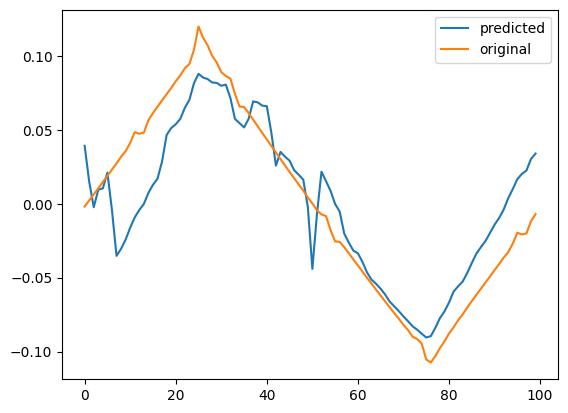

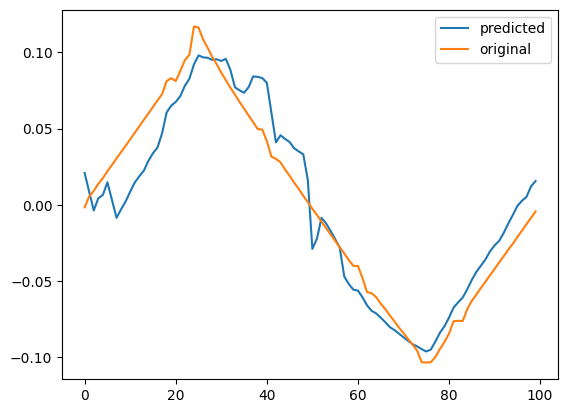

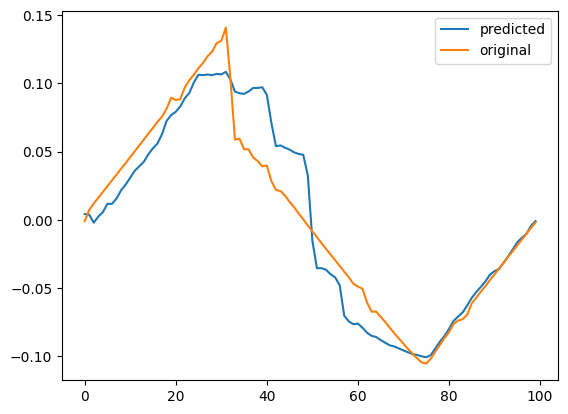

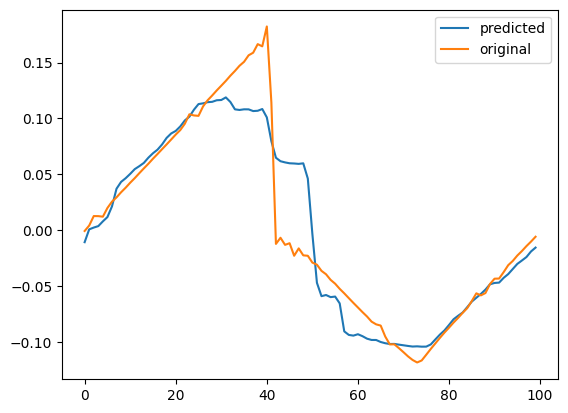

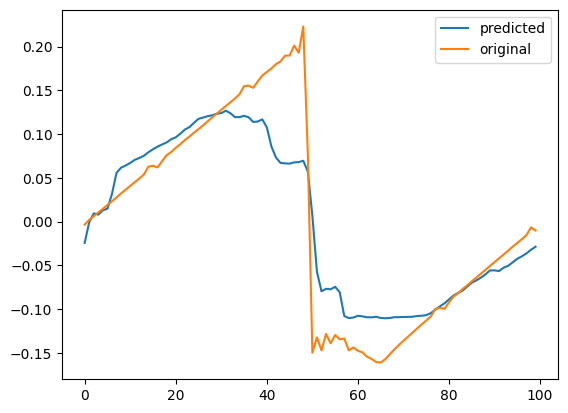

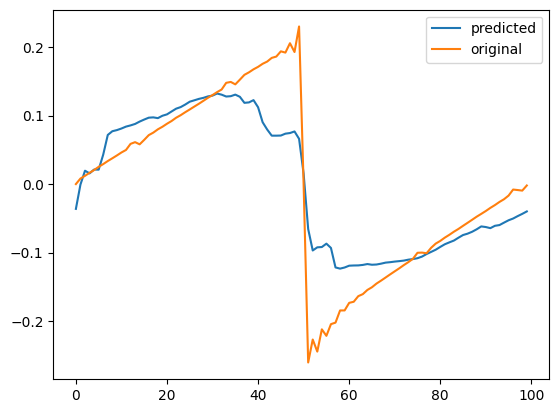

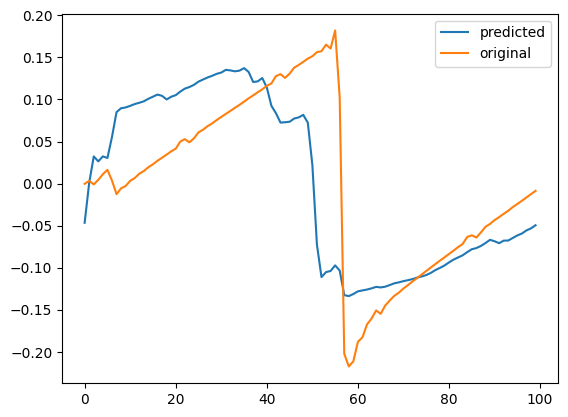

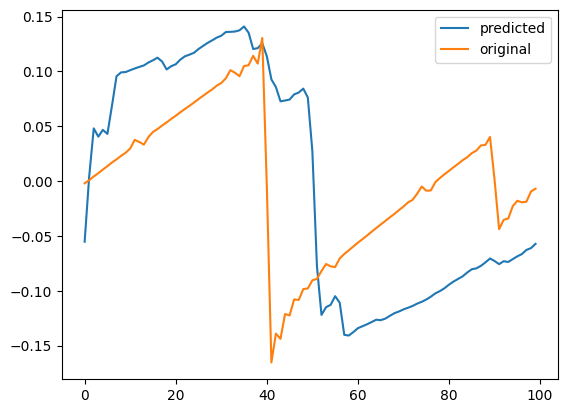

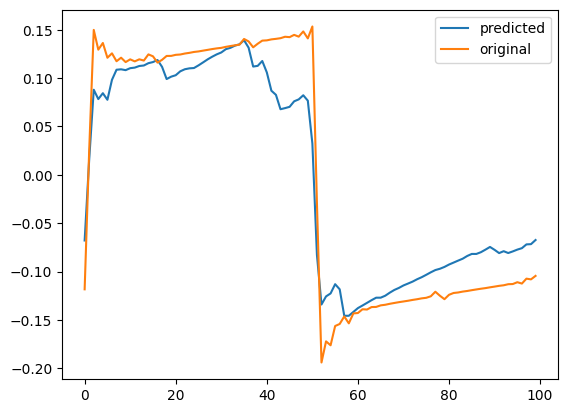

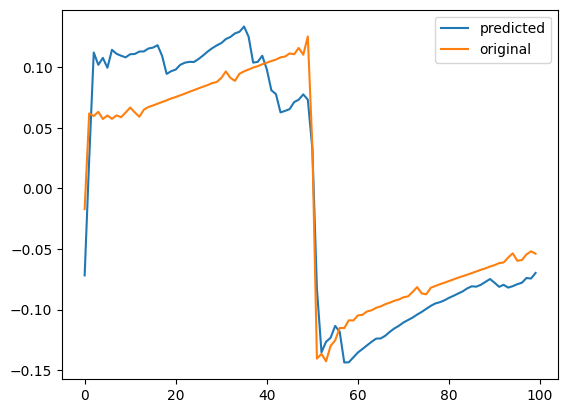

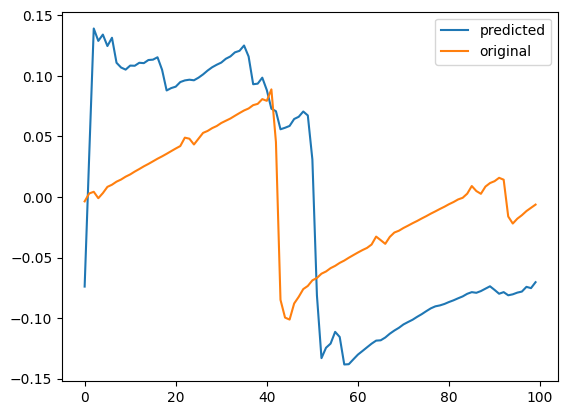

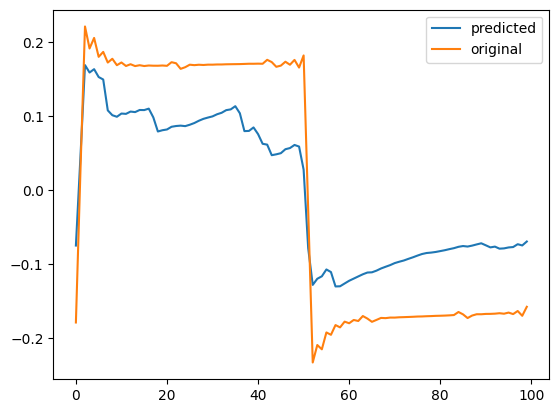

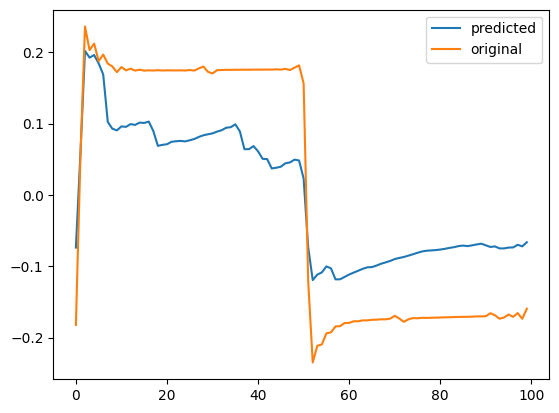

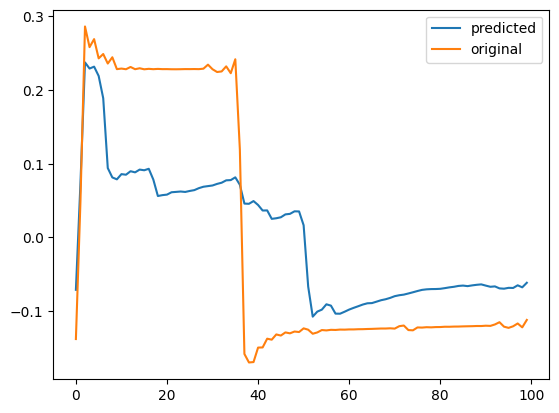

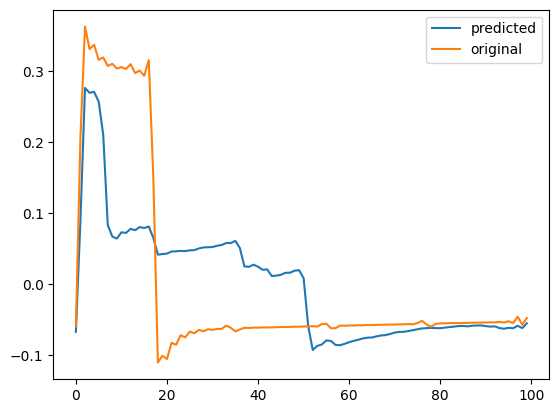

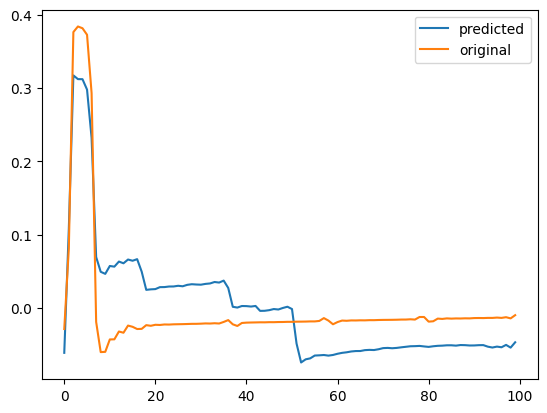

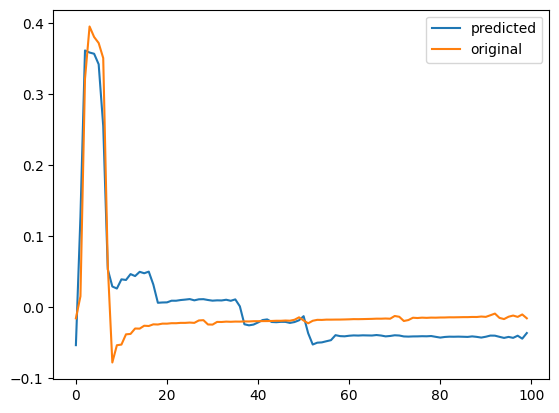

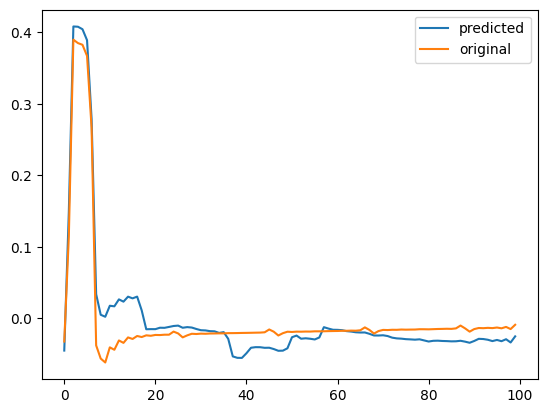

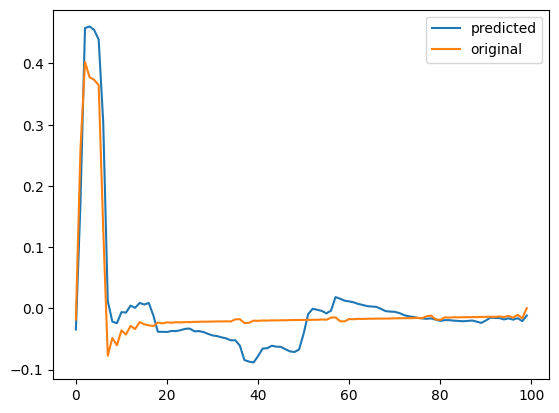

In [10]:
# pot_test = 0.22
# output = predicted_output_poly(pot_test)
# plt.plot(output, label = 'predicted')

for i in range(len(pot_values)):
    output = predicted_output_poly(pot_values[i], 2)
    plt.plot(output, label="predicted")
    plt.plot(audios[i], label="original")
    plt.legend()
    plt.show()

# Logarithmic Regression


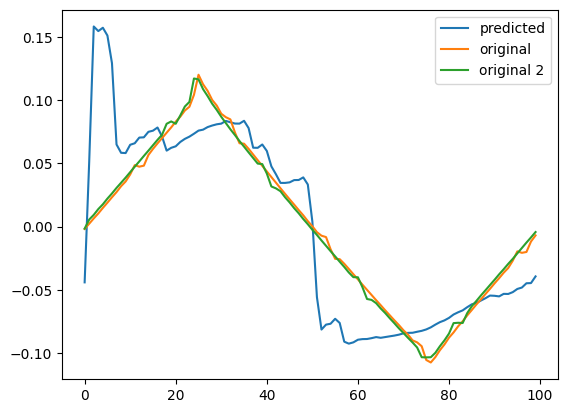

In [11]:
def predicted_output_log(pot_value, pot_values, audios):
    if pot_value < 0 or pot_value > 4:
        raise ValueError("Pot value must be between 0 and 4")
    small_value = 1e-10  # Small constant value to avoid zero or negative values
    log_pot_values = np.log(pot_values + small_value)
    lin_reg = LinearRegression()
    lin_reg.fit(log_pot_values.reshape(-1, 1), audios)
    log_pot_value = np.log(pot_value + small_value)
    audio_pred = lin_reg.predict([[log_pot_value]])
    return audio_pred[0]


a = predicted_output_log(1, pot_values, audios)
plt.plot(a, label="predicted")
plt.plot(audios[0], label="original")
plt.plot(audios[1], label="original 2")
plt.legend()
plt.show()

# Random Forest


### Find Best Params 1


In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [None, 5, 10, 15, 20, 25, 30],
    "min_samples_split": [2, 5, 10, 15, 20],
    "min_samples_leaf": [1, 2, 5, 10, 15],
}

rf = RandomForestRegressor()
rf_grid = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)
rf_grid.fit(pot_values.reshape(-1, 1), audios[:, 0])
best_params = rf_grid.best_params_

models = [
    RandomForestRegressor(
        n_estimators=best_params["n_estimators"],
        max_depth=best_params["max_depth"],
        min_samples_split=best_params["min_samples_split"],
        min_samples_leaf=best_params["min_samples_leaf"],
    ).fit(pot_values.reshape(-1, 1), audios[:, i])
    for i in range(audios.shape[1])
]


def predicted_RF(pot_value):
    return np.array([model.predict([[pot_value]])[0] for model in models])

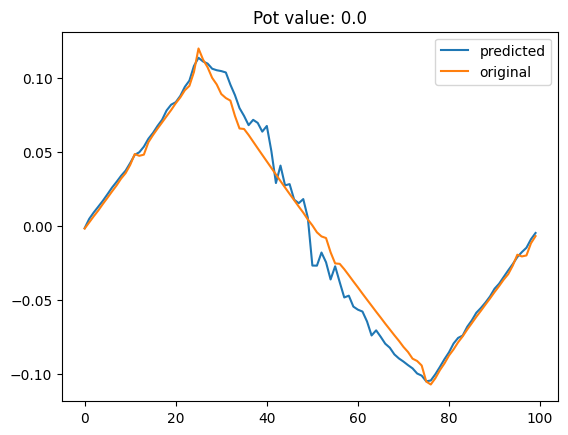

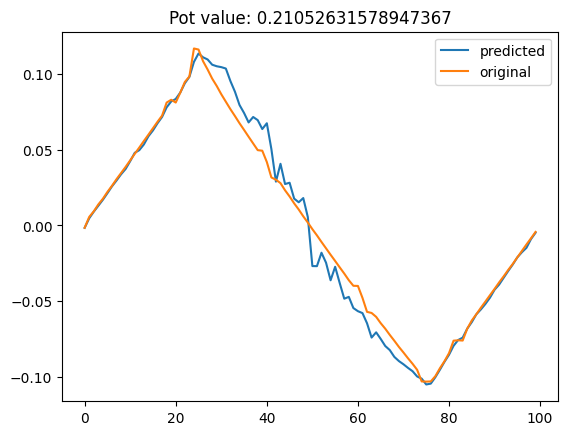

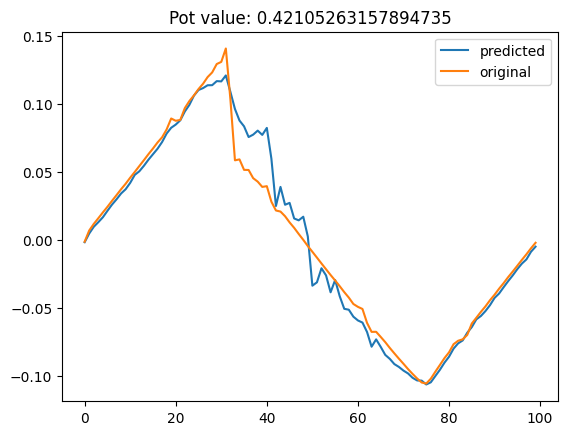

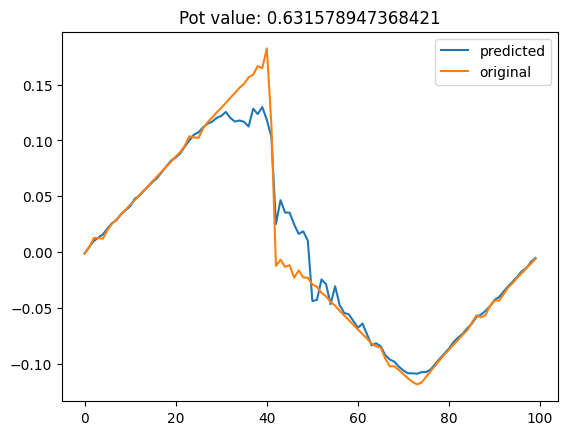

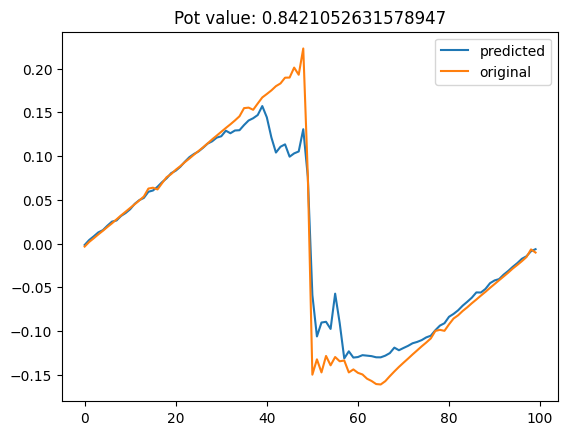

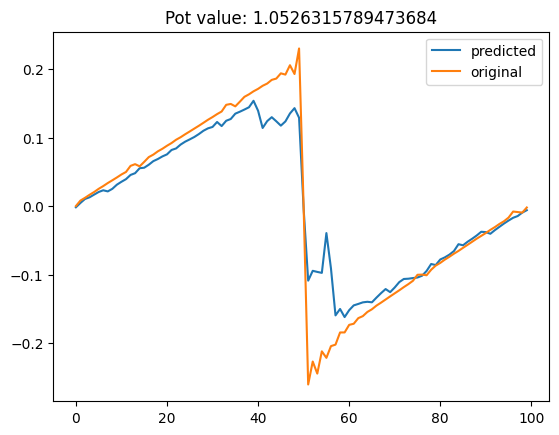

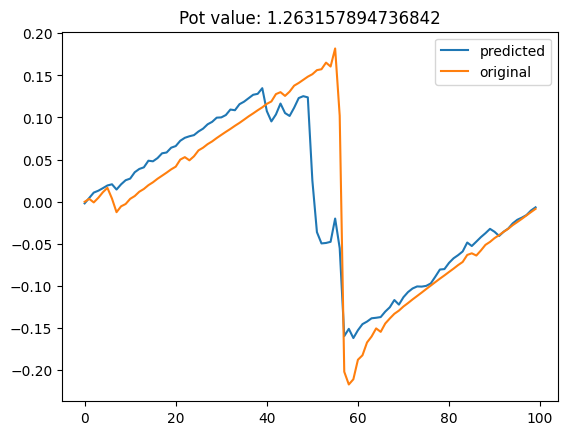

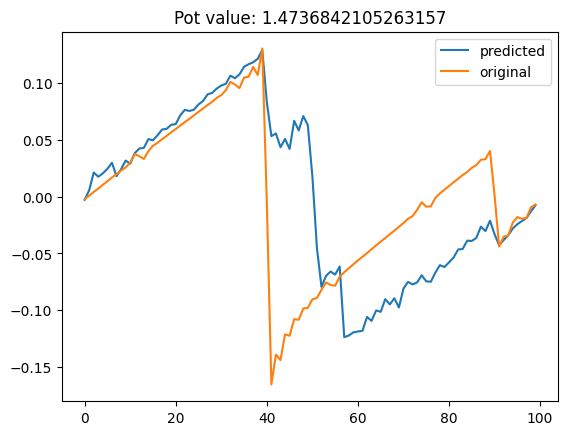

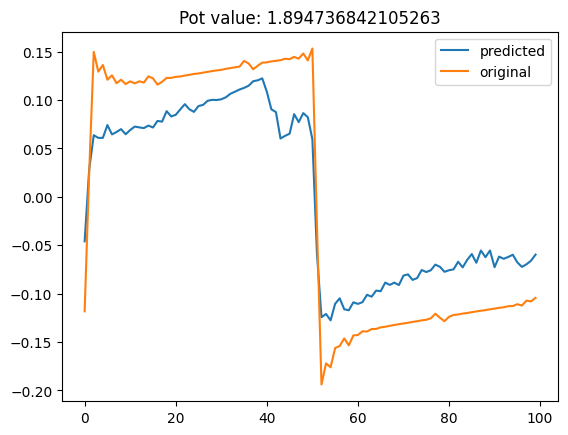

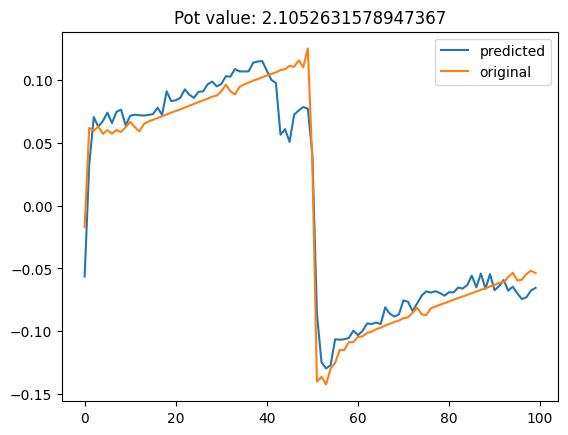

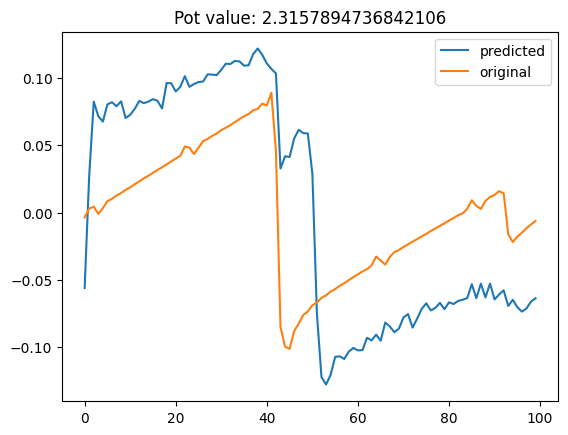

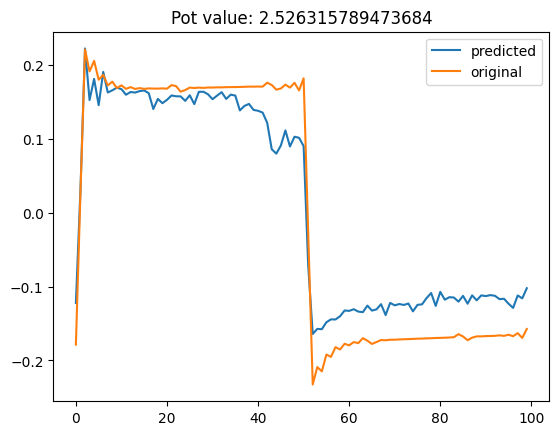

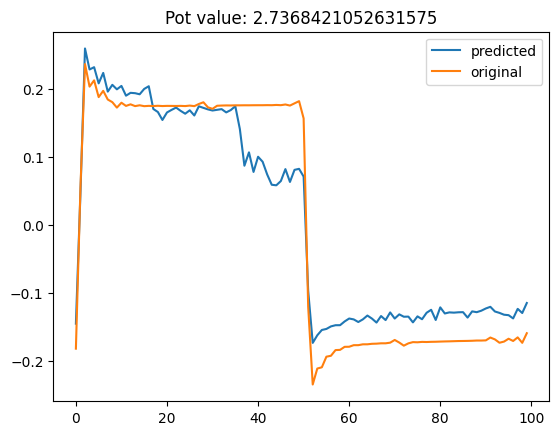

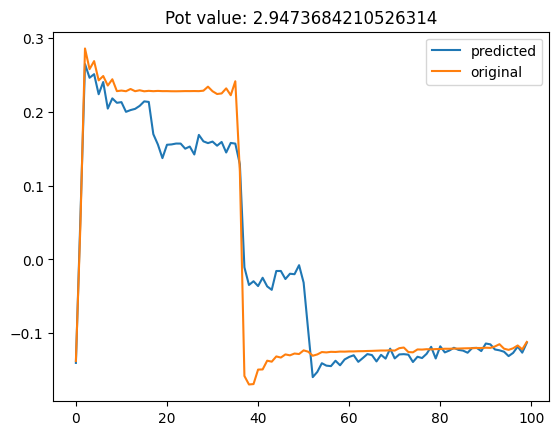

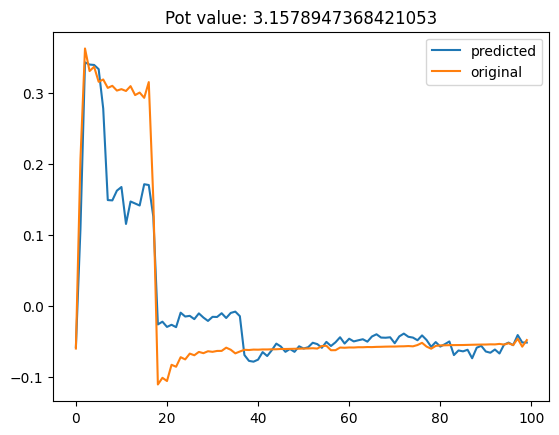

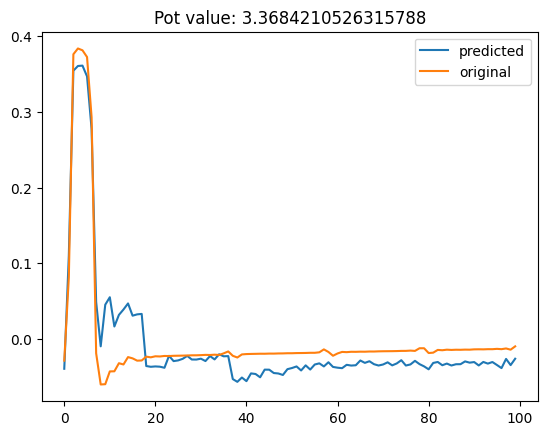

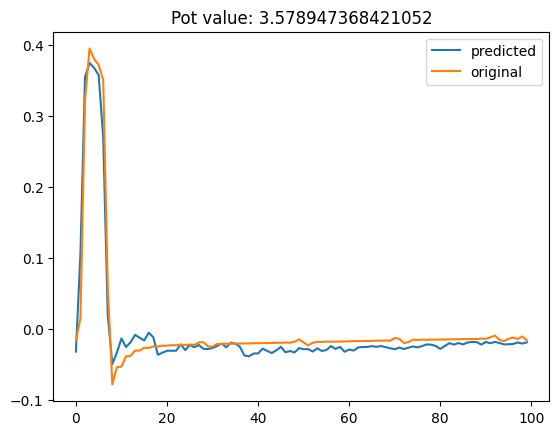

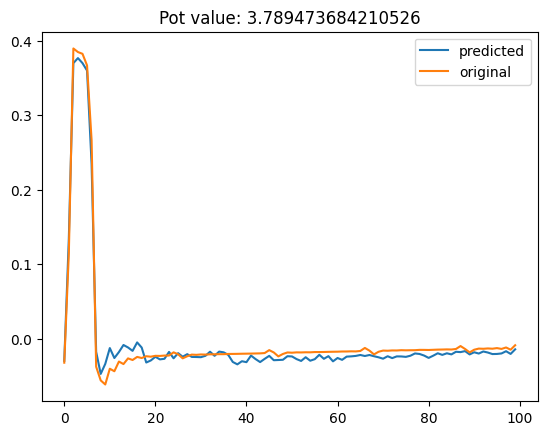

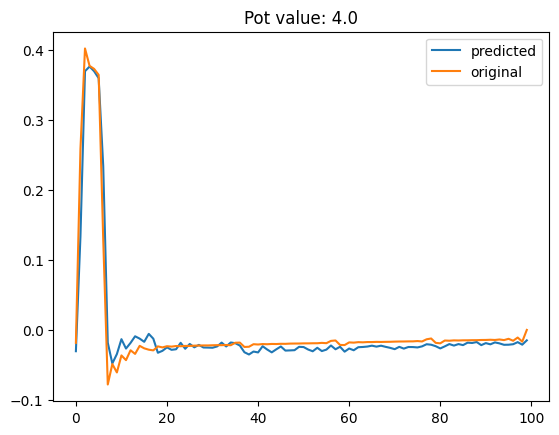

In [13]:
for i in range(len(pot_values)):
    output = predicted_RF(pot_values[i])
    plt.title(f"Pot value: {pot_values[i]}")
    plt.plot(output, label="predicted")
    plt.plot(audios[i], label="original")
    plt.legend()
    plt.show()

### Find Best params 2


In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameters to tune and their values
param_dist = {
    "n_estimators": [10, 50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
}

# Initialize an array to hold the models
models = []

# Train a separate model for each sample point
for i in range(audios.shape[1]):
    # Initialize a new Random Forest Regressor
    model = RandomForestRegressor()

    # Initialize the Random Search CV
    random_search = RandomizedSearchCV(
        estimator=model, param_distributions=param_dist, cv=5, n_jobs=-1
    )

    # Fit the model
    random_search.fit(pot_values.reshape(-1, 1), audios[:, i])

    # Get the best model
    best_model = random_search.best_estimator_

    # Add the best model to the list
    models.append(best_model)


def predicted_RF(pot_value):
    return np.array([model.predict([[pot_value]])[0] for model in models])

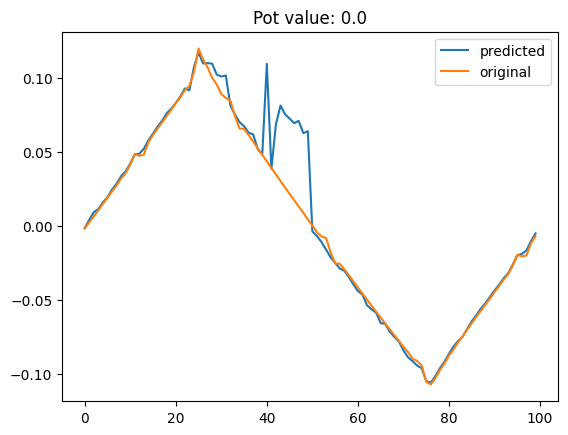

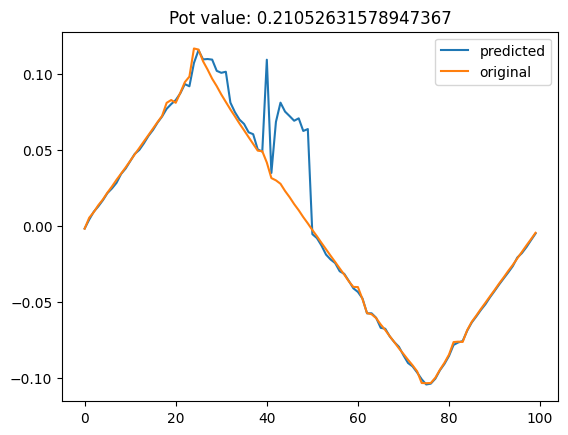

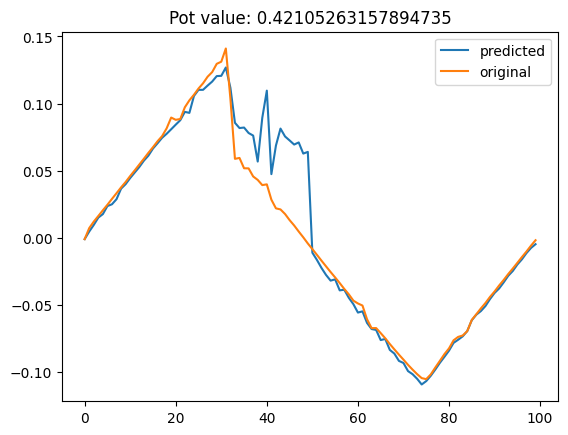

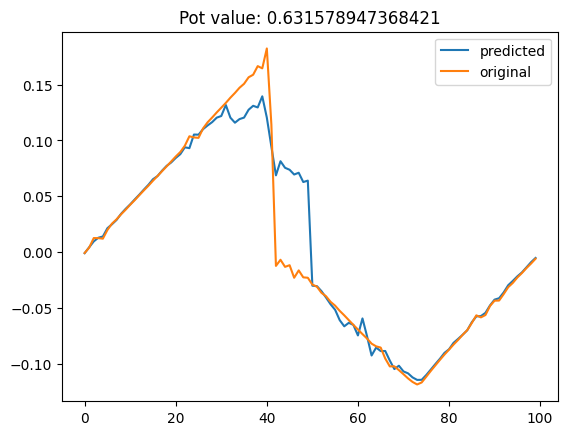

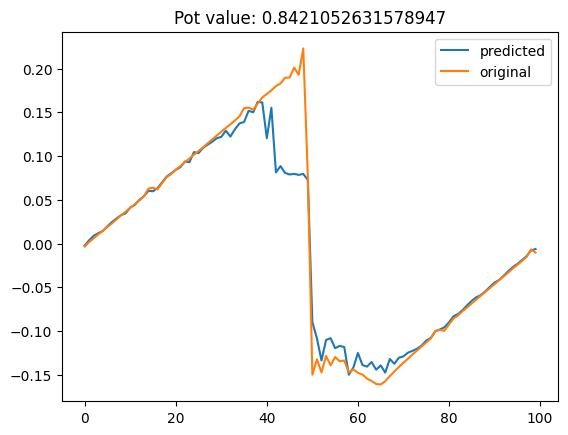

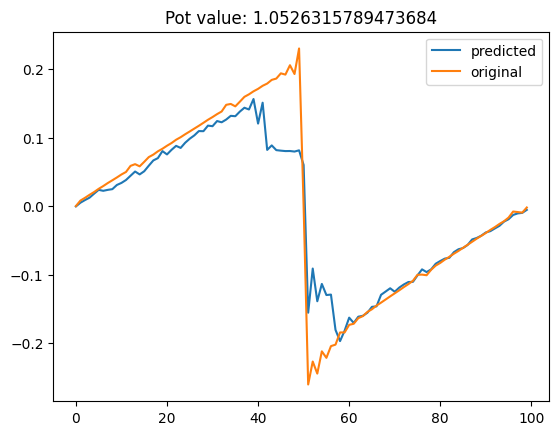

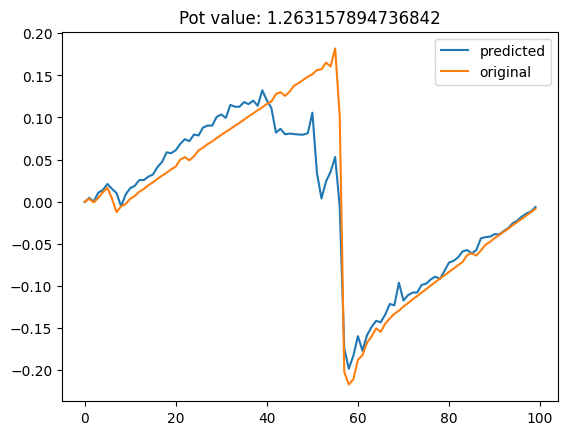

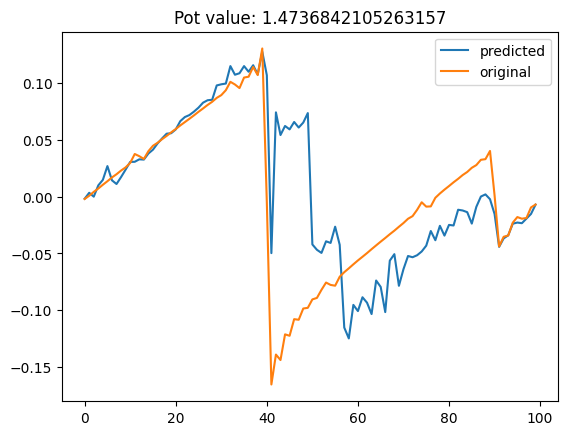

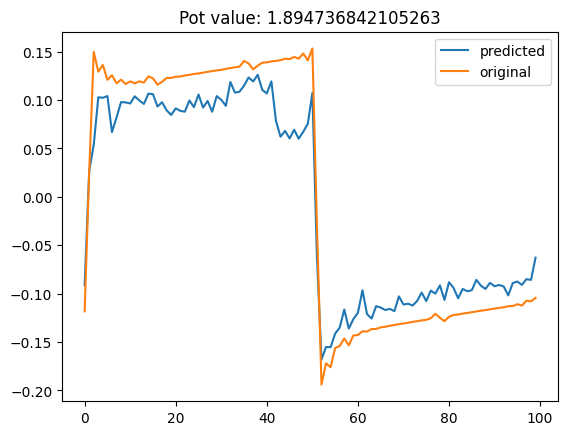

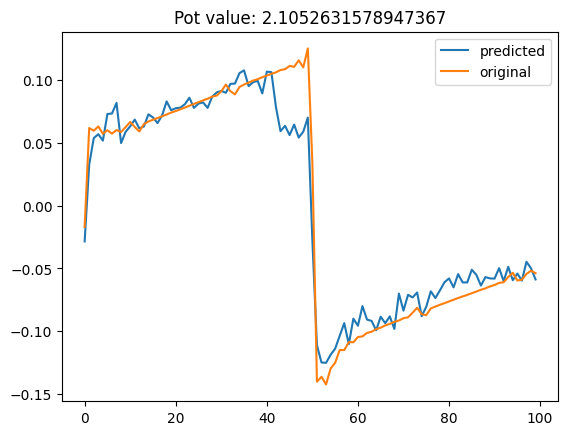

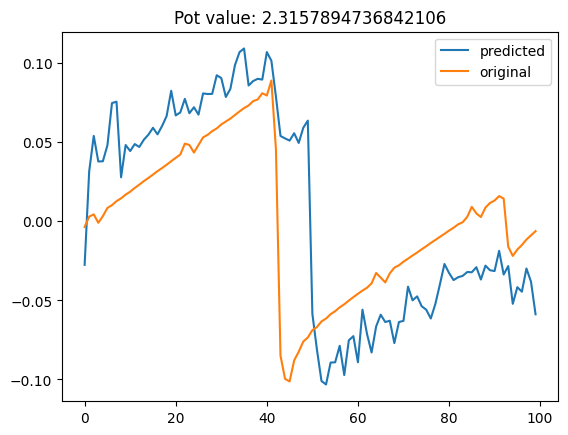

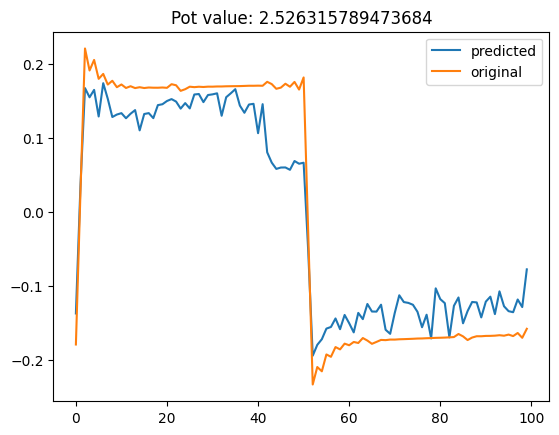

KeyboardInterrupt: 

In [15]:
for i in range(len(pot_values)):
    output = predicted_RF(pot_values[i])
    plt.title(f"Pot value: {pot_values[i]}")
    plt.plot(output, label="predicted")
    plt.plot(audios[i], label="original")
    plt.legend()
    plt.show()

# RNN


## Working


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# Standardize the pot_values
scaler = StandardScaler()
pot_values_scaled = scaler.fit_transform(pot_values.reshape(-1, 1))

# Define the model
model = Sequential()
model.add(Bidirectional(LSTM(64, input_shape=(None, 1))))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(audios.shape[1]))

# Compile the model with a smaller learning rate
opt = Adam(lr=0.001)
model.compile(loss="mean_squared_error", optimizer=opt)

# Reshape the data to fit the model
X = pot_values_scaled.reshape(-1, 1, 1)
Y = audios

# Train the model for more epochs
model.fit(X, Y, epochs=3000, batch_size=128)


# Define a function to make predictions
def predicted_RNN(pot_value):
    pot_value_scaled = scaler.transform(np.array([[pot_value]]))
    return model.predict(pot_value_scaled.reshape(1, 1, 1))[0]

### graphs


In [ ]:
for i in range(len(pot_values)):
    plt.title(f"Pot value: {pot_values[i]}")
    output = predicted_RNN(pot_values[i])
    plt.plot(output, label="predicted")
    plt.plot(audios[i], label="original")
    plt.legend()
    plt.show()

## trials


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler

# Standardize the pot_values
scaler = StandardScaler()
pot_values_scaled = scaler.fit_transform(pot_values.reshape(-1, 1))

# Define the model
model = Sequential()
model.add(Bidirectional(LSTM(64, input_shape=(None, 1))))
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(audios.shape[1]))

# Compile the model with a smaller learning rate
opt = Adam(lr=0.001)
model.compile(loss="mean_squared_error", optimizer=opt)

# Create the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.95, patience=25, min_delta=5e-7)

# Reshape the data to fit the model
X = pot_values_scaled.reshape(-1, 1, 1)
Y = audios

# Train the model for more epochs with the ReduceLROnPlateau callback
model.fit(X, Y, epochs=3000, batch_size=128, callbacks=[reduce_lr])


# Define a function to make predictions
def predicted_RNN(pot_value):
    pot_value_scaled = scaler.transform(np.array([[pot_value]]))
    return model.predict(pot_value_scaled.reshape(1, 1, 1))[0]

### graphs


In [ ]:
for i in range(len(pot_values)):
    plt.title(f"Pot value: {pot_values[i]}")
    output = predicted_RNN(pot_values[i])
    plt.plot(output, label="predicted")
    plt.plot(audios[i], label="original")
    plt.legend()
    plt.show()

predictions_RNN = np.array([predicted_RNN(pot_value) for pot_value in pot_values])

# Sound


In [ ]:
from IPython.display import Audio


def repeat_audio(signal, n_repeat=1):
    return np.concatenate([signal for _ in range(n_repeat)])


predicted_audio = [
    repeat_audio(predictions_RNN[i], 441) for i in range(len(predictions_RNN))
]

audio_from_periods = [repeat_audio(audios[i], 441) for i in range(len(audios))]

In [ ]:
Audio(predicted_audio[-1], rate=44100)

In [ ]:
Audio(audio_from_periods[-1], rate=44100)

In [ ]:
Audio(audio_data[-1], rate=44100)

In [ ]:
new_predicted_audio = predicted_RNN(3.6)
Audio(repeat_audio(new_predicted_audio, 441), rate=44100)